# Try an InfoGAN on MNIST

In [1]:
%matplotlib inline
#Import a ton of stuff
import os
import struct
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from layers import Conv2d, ConvTranspose2d, Linear
from InfoGAN import InfoGAN
torch.cuda.empty_cache()

# Insert the tInfo model to the framework

## Load the MNIST Data

In [2]:
#reference the InfoGAN part from https://github.com/HenryJia/InfoGAN

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

data_train = read_idx('./MNIST_Data/train-images.idx3-ubyte')
data_test = read_idx('./MNIST_Data/t10k-images.idx3-ubyte')

targets_train = read_idx('./MNIST_Data/train-labels.idx1-ubyte')
targets_test = read_idx('./MNIST_Data/t10k-labels.idx1-ubyte')
print(data_train.shape, data_test.shape, targets_train.shape, targets_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


In [3]:
label1 = 4
label2 = 9
#for traiing set
#delete those labels are not from a or b 
delete_index = []
for i in range(targets_train.shape[0]):
    if targets_train[i] != label1 and targets_train[i] != label2:
        delete_index.append(i)

#delete from training set 
data_train = np.delete(data_train, delete_index,0)
targets_train = np.delete(targets_train,delete_index,0)

#get the label from 4 and 9 to 0 and 1 
for i in range(targets_train.shape[0]):
    if targets_train[i] == label1: 
        targets_train[i] = 0
    else:
        targets_train[i] = 1
        
print(data_train.shape)
print(targets_train.shape)
print(targets_train[0])

#for testing set
#delete those labels are not from a or b 
delete_index = []
for i in range(targets_test.shape[0]):
    if targets_test[i] != label1 and targets_test[i] != label2:
        delete_index.append(i)
        
#delete from training set 
data_test = np.delete(data_test, delete_index,0)
targets_test = np.delete(targets_test,delete_index,0)

for i in range(targets_test.shape[0]):
    if targets_test[i] == label1: 
        targets_test[i] = 0
    else:
        targets_test[i] = 1

print(data_test.shape)
print(targets_test.shape)
print(targets_test[0])

(11791, 28, 28)
(11791,)
0
(1991, 28, 28)
(1991,)
0


In [4]:
# Now reformat it into the format we want
# NOTE: PyTorch is weird so if we wanted to use cross entropy we need to keep them as logits, but we won't so...
x_train = np.expand_dims(data_train, 1)
y_train = np.zeros((targets_train.shape[0], 2), dtype = np.uint8)
y_train[np.arange(targets_train.shape[0]), targets_train] = 1

x_test = np.expand_dims(data_test, 1)
y_test = np.zeros((data_test.shape[0], 2), dtype = np.uint8)
y_test[np.arange(targets_test.shape[0]), targets_test] = 1

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Looks like we can convert our x to unint8
# We'll convert back to float and rescale to between 0 and 1 on the GPU batchwise to save CPU RAM
print(np.unique(x_train))
x_train = x_train.astype(np.uint8)
x_test = x_test.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_test = y_test.astype(np.uint8)

(11791, 1, 28, 28) (11791, 2)
(1991, 1, 28, 28) (1991, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

[1 0]


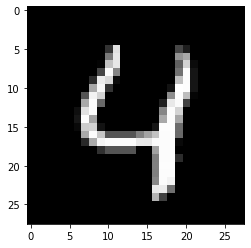

In [5]:
# Show an example from the test set
print(y_test[0])
plt.figure(0)
plt.imshow(x_test[0, 0], cmap = 'gray')

## PyTorch-ify our data and set the number of random samples we want to supervise with

In [6]:
supervision = 100 # Number of samples to supervise with

# Prep the data by turning them into tensors and putting them into a PyTorch dataloader
shuffle_train = np.random.permutation(y_train.shape[0])
x_train_th = torch.from_numpy(x_train[shuffle_train])
y_train_th = torch.from_numpy(y_train[shuffle_train]).float()

x_test_th = torch.from_numpy(x_test)
y_test_th = torch.from_numpy(y_test)

# OK, we're going to be hacking this out. We'll multiply by the sum of the labels
# So to make this semisupervised, we set the labels we don't want to 0
y_train_th[int(supervision):] = 0

train_tensors = TensorDataset(x_train_th, y_train_th)
test_tensors = TensorDataset(x_test_th, y_test_th)
train_loader = DataLoader(train_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)
test_loader = DataLoader(test_tensors, batch_size = 128, shuffle = True, num_workers = 6, pin_memory = True)

## Create our network
* c1_len is the length of the multinomial coding vector
* c2_len is the length of the Gaussian coding vector
* c3_len is the length of the Bernoulli coding vector. Note the original paper doesn't using any bernoulli codes
* z_len is the length of the noise vector
* embedding_len is  the length of the embedding output from the discriminator to compute the latent codes

In [7]:
# Now let's start building the GAN
# But first, we're going to redefine Conv2D and Linear with our own initialisations
# We're going to use Glorot (aka Xavier) uniform init for all weights
# And we will use zero init for all biases

c1_len = 2 # Multinomial
c2_len = 10 # Gaussian
c3_len = 10 # Bernoulli
z_len = 64 # Noise vector length
embedding_len = 128

class Conv2d(nn.Conv2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class ConvTranspose2d(nn.ConvTranspose2d):
    def reset_parameters(self):
        stdv = np.sqrt(6 / ((self.in_channels  + self.out_channels) * np.prod(self.kernel_size)))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Linear(nn.Linear):
    def reset_parameters(self):
        stdv = np.sqrt(6 / (self.in_features + self.out_features))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.zero_()

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = Linear(z_len + c1_len + c2_len + c3_len, 1024)
        self.fc2 = Linear(1024, 7 * 7 * 128)

        self.convt1 = ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.convt2 = ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1)

        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(7 * 7 * 128)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x))).view(-1, 128, 7, 7)

        x = F.relu(self.bn3(self.convt1(x)))
        x = self.convt2(x)

        return F.sigmoid(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = Conv2d(1, 64, kernel_size = 4, stride = 2, padding = 1) # 28 x 28 -> 14 x 14
        self.conv2 = Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1) # 14 x 14 -> 7 x 7

        self.fc1 = Linear(128 * 7 ** 2, 1024)
        self.fc2 = Linear(1024, 1)
        self.fc1_q = Linear(1024, embedding_len)

        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn_q1 = nn.BatchNorm1d(embedding_len)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.bn1(self.conv2(x))).view(-1, 7 ** 2 * 128)

        x = F.leaky_relu(self.bn2(self.fc1(x)))
        return self.fc2(x), F.leaky_relu(self.bn_q1(self.fc1_q(x)))

In [8]:
# OK, now we create the actual models
gen = Generator().cuda()
dis = Discriminator().cuda()

In [9]:
# Link it all together into the InfoGAN. Also add the output layers for the latent codes
gan = InfoGAN(gen, dis, embedding_len, z_len, c1_len, c2_len, c3_len)

In [10]:
print(gan.Q_cat)
print(gen)
print(dis)

Linear(in_features=128, out_features=2, bias=True)
Generator(
  (fc1): Linear(in_features=86, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=6272, bias=True)
  (convt1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convt2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
  (fc1_q): Linear(in_features=1024, out_features=128, bias=True)
  (bn1

In [11]:
# train the generator model 
# gan.train_all(train_loader)

In [12]:
# gan.save('./mnist/4_9/')

In [13]:
gan.load('./mnist/4_9/')

In [14]:
#target model referenced from https://github.com/mathcbc/advGAN\_pytorch
class MNIST_target_net(nn.Module):
    def __init__(self):
        super(MNIST_target_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)

        self.fc1 = nn.Linear(64*4*4, 200)
        self.fc2 = nn.Linear(200, 200)
        self.logits = nn.Linear(200, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = F.relu(self.fc2(x))
        x = self.logits(x)
        return x
    
target_model = MNIST_target_net()
print(target_model)
target_model.load_state_dict(torch.load('MNIST_target_model_49.pth'))

MNIST_target_net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (logits): Linear(in_features=200, out_features=2, bias=True)
)


<All keys matched successfully>

# Explanation between 4 and 9 

In [15]:
out_test = gan.run_dis(Variable(x_test_th).cuda().float() / 255)[1]
print(out_test.shape)
out_test = np.argmax(out_test.data.cpu().numpy(), axis = 1)

torch.Size([1991, 2])


/home/finn/Documents/InfoGAN/InfoGAN/InfoGAN.py:172: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out += [F.softmax(self.Q_cat(hid))]
/home/finn/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [16]:
print(np.mean(out_test == np.argmax(y_test, axis = 1)))

0.9814163736815671


the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0

the predicted label is 1

the correct label is 0

the predicted label is 1

the correct label is 0

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0

the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0

the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0

the predicted label is 0

the correct label is 1

the predicted label is 0

the correct label is 1

the predicted label is 1

the correct label is 0



/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


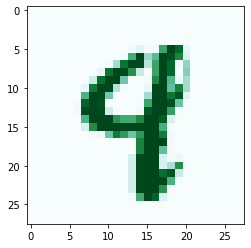

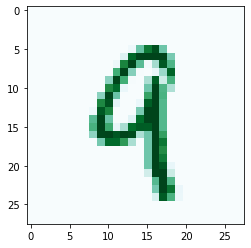

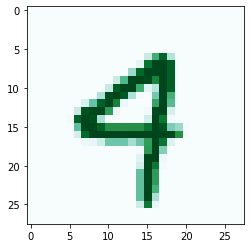

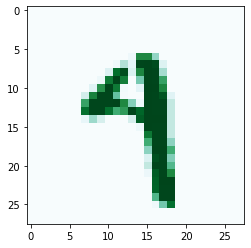

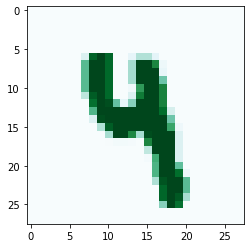

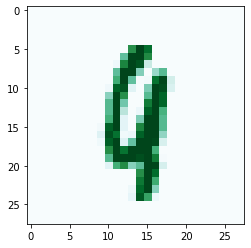

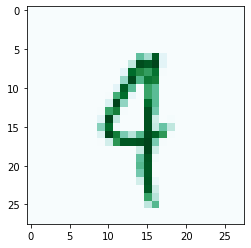

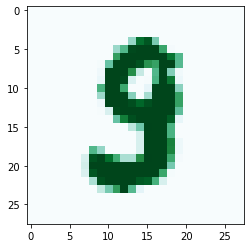

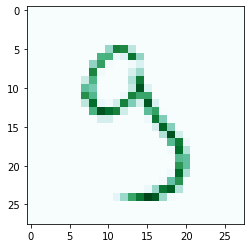

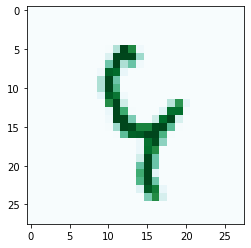

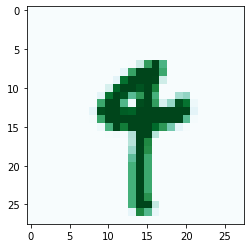

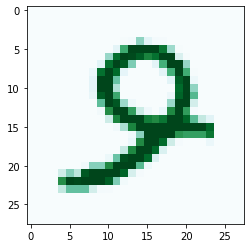

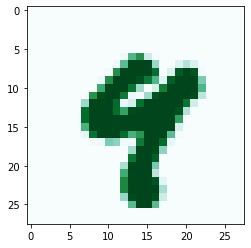

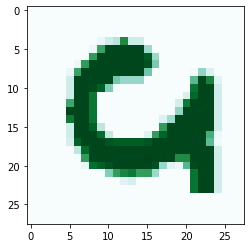

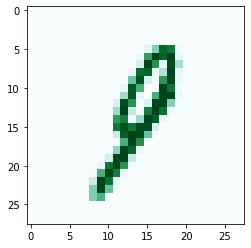

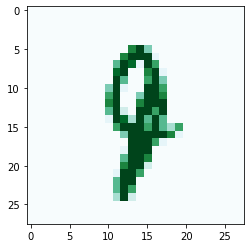

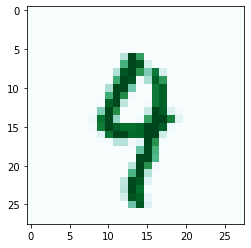

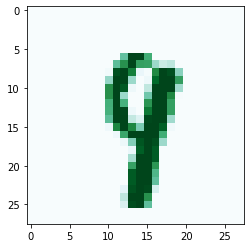

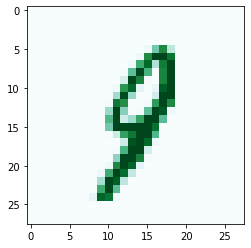

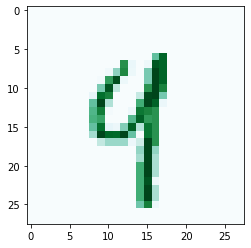

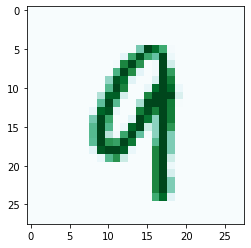

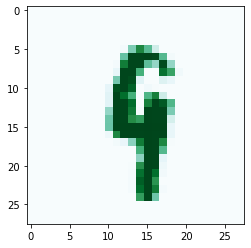

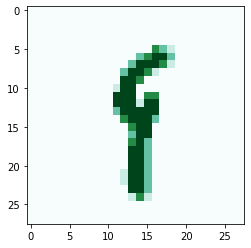

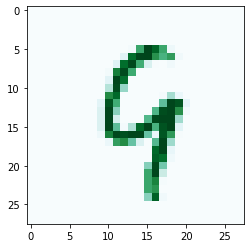

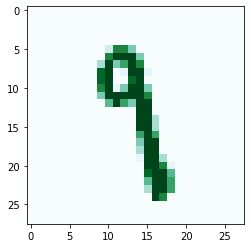

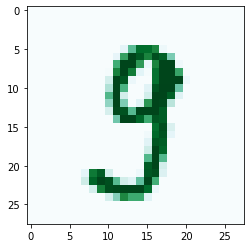

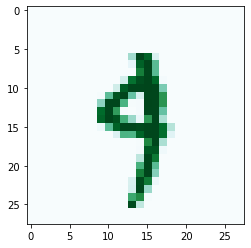

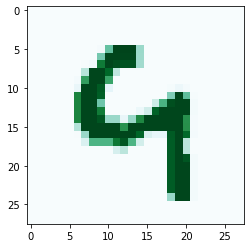

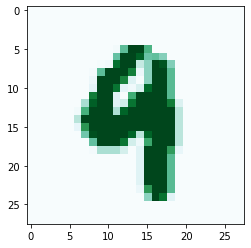

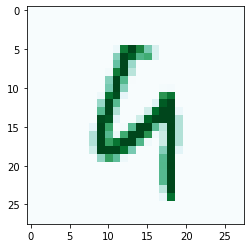

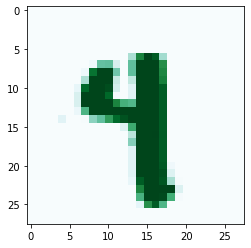

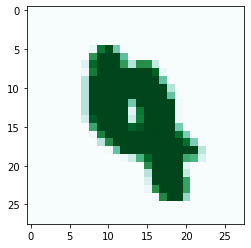

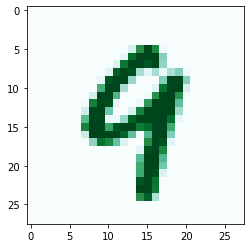

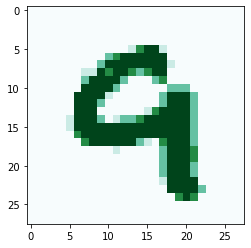

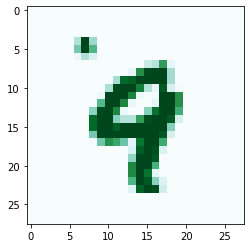

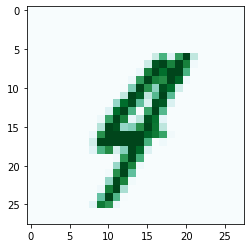

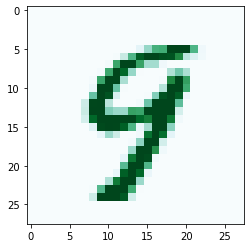

In [17]:
#initial instance selection
ground_label = list(np.argmax(y_test, axis = 1))
mis_index_list = []
mis_image = []
num_max = 0
for j in range(out_test.shape[0]):
    if out_test[j] != ground_label[j]:
        mis_index_list.append(j)
        mis_image.append(x_test[j])
        num_max = num_max + 1
        if num_max < 50:
            print('the predicted label is {}\n'.format(out_test[j]))
            print('the correct label is {}\n'.format(ground_label[j]))
            plt.figure()
            plt.imshow(x_test[j, 0], cmap = 'BuGn')

In [19]:
#get the first index used in the experiment 
index_exp = mis_index_list[2]
pred_exp = out_test[index_exp]
trueth_exp = ground_label[index_exp]
print('the experiment index is {}, the correct label is {} but the predicted label is {}'.format(index_exp,trueth_exp,pred_exp))

the experiment index is 125, the correct label is 0 but the predicted label is 1


In [20]:
#get the constructed
contructed_index_exp = gan.run_dis(Variable(x_test_th).cuda().float() / 255)
print(len(contructed_index_exp))
# get the z 
contructed_z = contructed_index_exp[0][index_exp]
print('the shape of z is {}'.format(contructed_z.shape))
print(contructed_z)
#get the c1 
contructed_c1 = contructed_index_exp[1][index_exp]
print('the shape of c1 is {}'.format(contructed_c1.shape))
print(contructed_c1)
#get the c2 
contructed_c2 = contructed_index_exp[2][index_exp]
print('the shape of c2 is {}'.format(contructed_c2.shape))
print(contructed_c2)
#get the c3 
contructed_c3 = contructed_index_exp[3][index_exp]
print('the shape of c3 is {}'.format(contructed_c3.shape))
print(contructed_c3)

4
the shape of z is torch.Size([1])
tensor([0.3479], device='cuda:0', grad_fn=<SelectBackward>)
the shape of c1 is torch.Size([2])
tensor([0.0680, 0.9320], device='cuda:0', grad_fn=<SelectBackward>)
the shape of c2 is torch.Size([10])
tensor([-0.4894, -0.1772, -0.6963, -0.9048, -1.3735, -0.0245, -0.6976,  0.6206,
        -0.3893,  0.8523], device='cuda:0', grad_fn=<SelectBackward>)
the shape of c3 is torch.Size([10])
tensor([5.2968e-01, 9.9854e-01, 9.3216e-04, 9.9013e-01, 1.9690e-02, 2.8446e-03,
        1.3793e-06, 1.0000e+00, 9.1943e-01, 9.9693e-01], device='cuda:0',
       grad_fn=<SelectBackward>)


In [21]:
print(np.argmax(contructed_c1.data.cpu(), axis = 0))

tensor(1)


In [22]:
def convert_to_z(contructed_z, c1, c2, c3):
    a_list = []
#     for i in range(z_len):
#         a_list.append(contructed_z[0].data.cpu())
    for i in range(c1_len):
        a_list.append(c1[i].data.cpu())
    for i in range(c2_len):
        a_list.append(c2[i].data.cpu())
    for i in range(c3_len):
        a_list.append(c3[i].data.cpu())
    return a_list

In [23]:
converted_list = convert_to_z(contructed_z,contructed_c1,contructed_c2, contructed_c3)
print(converted_list)
print(len(converted_list))

[tensor(0.0680), tensor(0.9320), tensor(-0.4894), tensor(-0.1772), tensor(-0.6963), tensor(-0.9048), tensor(-1.3735), tensor(-0.0245), tensor(-0.6976), tensor(0.6206), tensor(-0.3893), tensor(0.8523), tensor(0.5297), tensor(0.9985), tensor(0.0009), tensor(0.9901), tensor(0.0197), tensor(0.0028), tensor(1.3793e-06), tensor(1.), tensor(0.9194), tensor(0.9969)]
22


In [24]:
#generator example 
z_dict = gan.get_z(c1_len , sequential = True)
b=torch.cat([z_dict[k] for k in z_dict.keys()], dim = 1)

In [25]:
#get corresponding class 
def get_color_class(cur_class):
    if cur_class == 0:
        return 'Reds'
    elif cur_class == 1:
        return 'Greens'
    elif cur_class == 2:
        return 'BuGn'
    elif cur_class == 3:
        return 'Reds'
    elif cur_class == 4:
        return 'OrRd'
    elif cur_class == 5:
        return 'PuBu'
    elif cur_class == 6:
        return 'Greens'
    elif cur_class == 7:
        return 'Blues'
    elif cur_class == 8:
        return 'GnBu'
    elif cur_class == 9:
        return 'bwr'
    else: 
        return 'bone'

#get original label     
def get_original_label(cur_label):
    if cur_label == 0:
        return label1
    else:
        return label2

In [26]:
#construct the initial instance
for i in range(2):
    for j in range(len(converted_list)):
        b[i][j+64] = converted_list[j]
print(b.shape)

torch.Size([2, 86])


In [56]:
#get original probability 
def get_string_probability(cur_prob_list):
    return_list = []
    for num in cur_prob_list[0]:
        new_num = float(("{:.10f}".format(num)))
        format(new_num, '.10f')
        return_list.append(format(new_num, '.10f'))

    return return_list

In [57]:
# for Gaussian distribution variables 
def plot_generated_examples_cont(category, idex_code, pos):  
    con_list_neg = [ 0,-0.5,-1,-1.5,-2.0,-2.5,-3,-3.5,-4,-4.5]
    con_list_pos = [ 0,0.5,1,1.5,2.0,2.5,3,3.5,4,4.5]
    
    
    import copy
    con_list = []
    if pos == True:
        con_list = con_list_pos
    else:
        con_list = con_list_neg
        
    fig = plt.figure(figsize=(16, 16))
    for i in range(len(con_list)):
            cur_z = copy.deepcopy(b)
            cur_z[category][idex_code+66] = cur_z[category][idex_code+66] + con_list[i]
            out_gen = gan.gen(cur_z)
            
            #use the discriminator to predict the generated image class and probability 
            img = out_gen[category].reshape(1,1,28,28).cpu()
            #use this to fix the output of the target model 
            target_out = target_model(img)
            
            #next get the classes and the probobility 
            prob = F.softmax(target_out).tolist()
            prob_return = get_string_probability(prob)

            cur_class = torch.argmax(target_out, 1)
            color = get_color_class(cur_class)
            
            
            #plot function 
            plt.subplot(1, len(con_list), i+1)
            plt.axis('off')
            plt.title('{}\n{}'.format(prob_return[0],prob_return[1]))
            plt.imshow(np.round(out_gen[category, 0].cpu().data.numpy() * 255), cmap = color)
    fig.tight_layout()        
    plt.show()

In [58]:
#for burnoulli distribution variable 
def plot_generated_examples_bur(category, idex_code, pos): 
    con_list_neg = [ 0,-1,-2,-3,-4,-5,-6,-7,-8,-9]
    con_list_pos = [ 0, 1, 2, 3, 4, 5, 6, 7, 8,9]
    import copy
    con_list = []
    if pos == True:
        con_list = con_list_pos
    else:
        con_list = con_list_neg
        
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(con_list)):
            cur_z = copy.deepcopy(b)
            cur_z[category][idex_code+76] = cur_z[category][idex_code+76] + con_list[i]
            out_gen = gan.gen(cur_z)
            
            #use the discriminator to predict the generated image class and probability 
            img = out_gen[category].reshape(1,1,28,28).cpu()
            #use this to fix the output of the target model 
            target_out = target_model(img)
            
            #next get the classes and the probobility 
            prob = F.softmax(target_out).tolist()
            prob_return = get_string_probability(prob)

            cur_class = torch.argmax(target_out, 1)
            color = get_color_class(cur_class)
            
            
            #plot function 
            plt.subplot(1, len(con_list), i+1)
            plt.axis('off')
            plt.title('{}\n{}'.format(prob_return[0],prob_return[1]))
            plt.imshow(np.round(out_gen[category, 0].cpu().data.numpy() * 255), cmap = color)
    fig.tight_layout()        
    plt.show()

# Dimension 2 

In [1]:
#same example used in the paper 

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


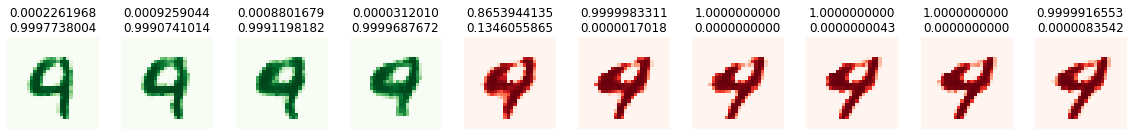

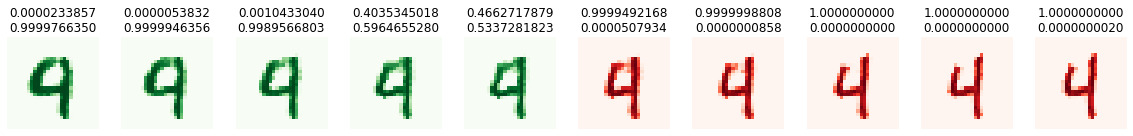

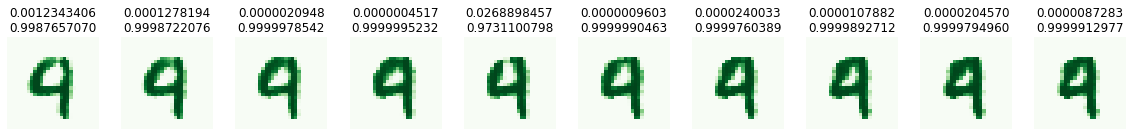

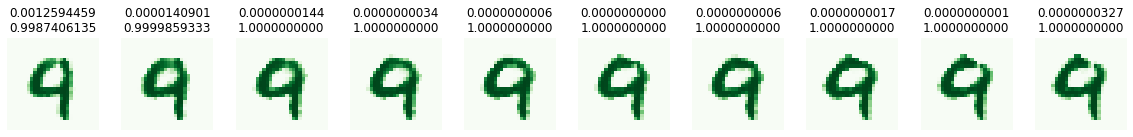

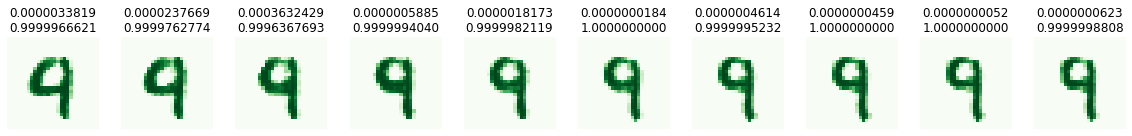

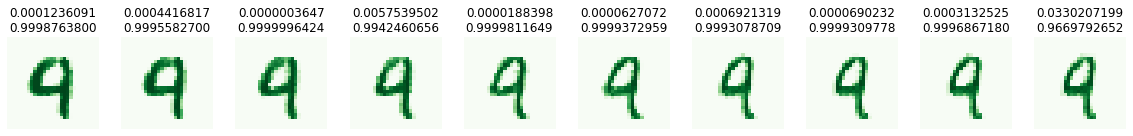

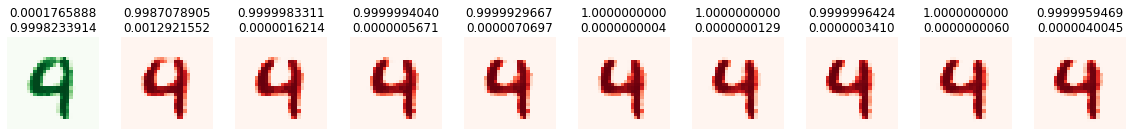

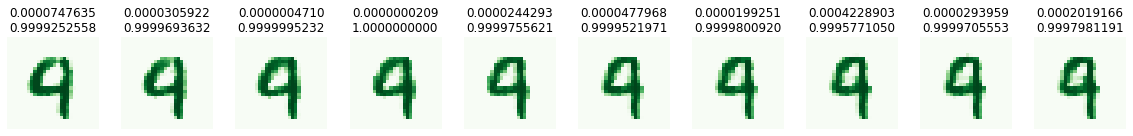

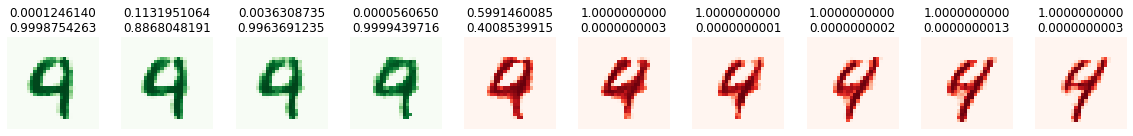

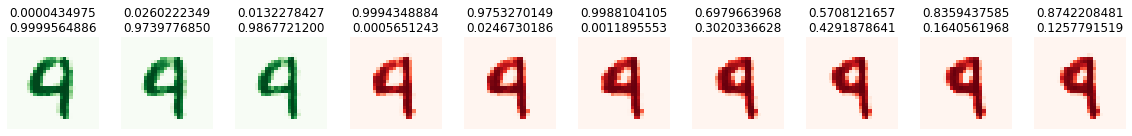

In [59]:
for i in range(10):
    plot_generated_examples_cont(1,i,True)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


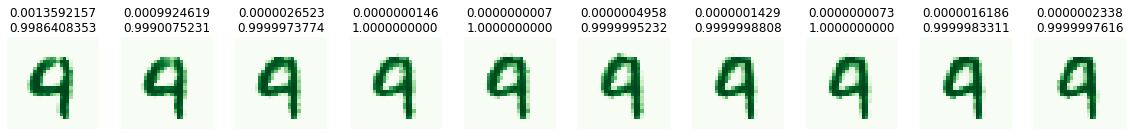

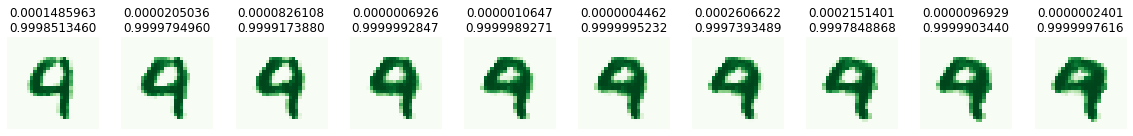

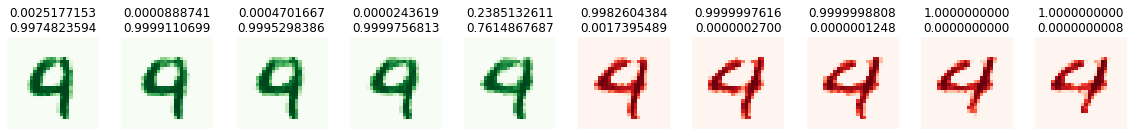

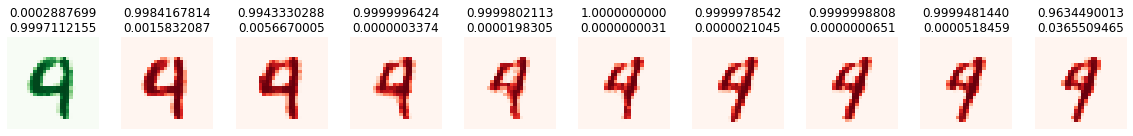

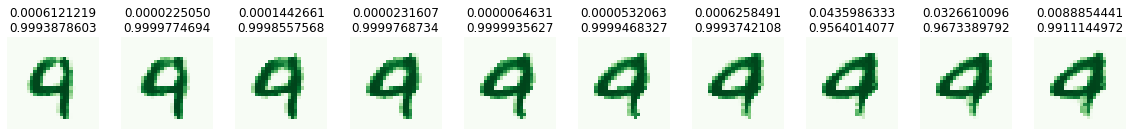

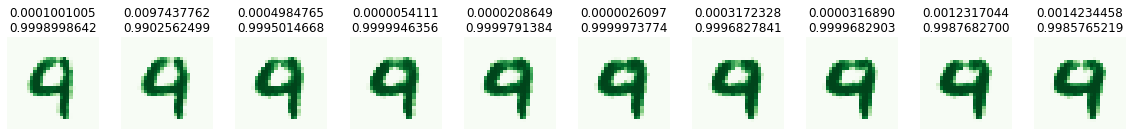

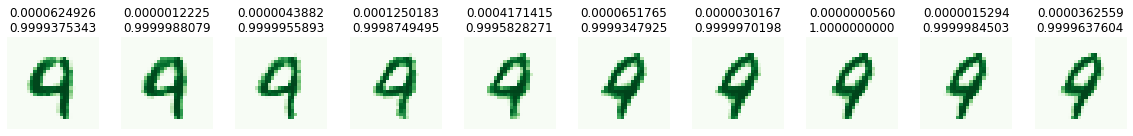

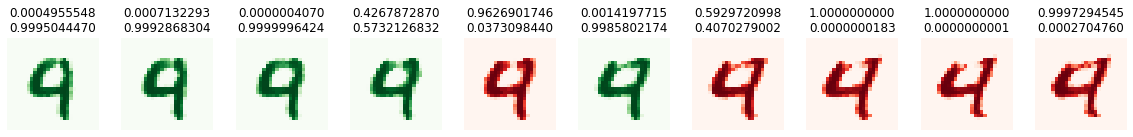

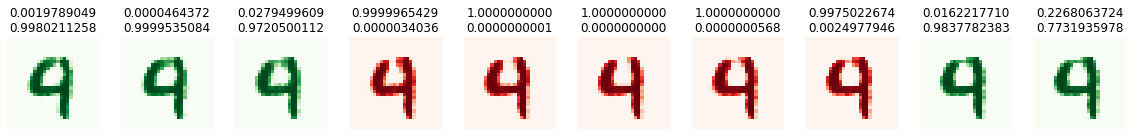

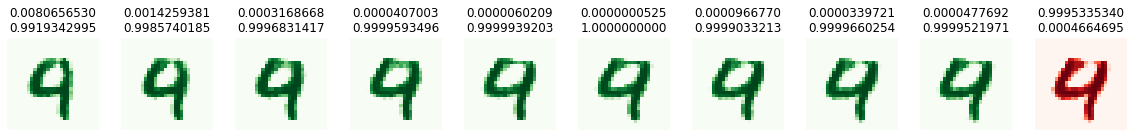

In [60]:
for i in range(10):
    plot_generated_examples_cont(1,i,False)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


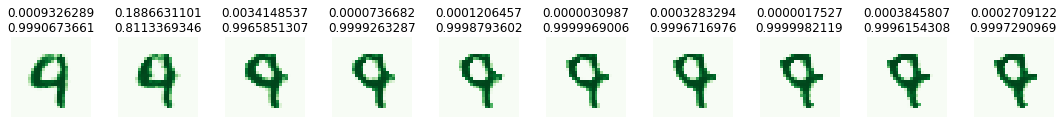

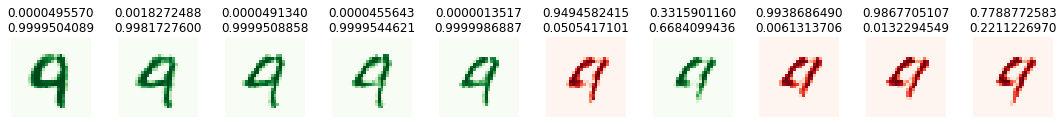

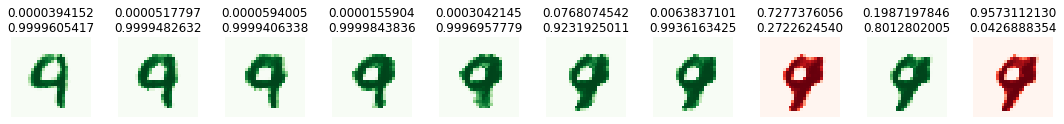

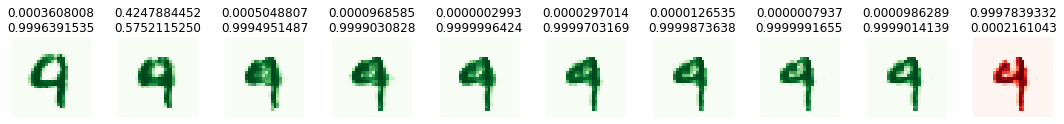

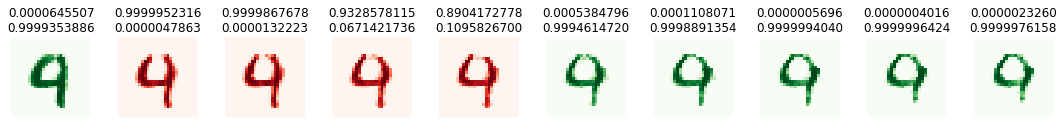

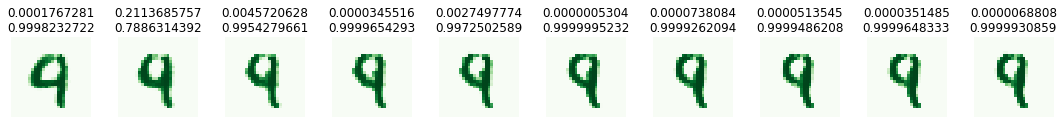

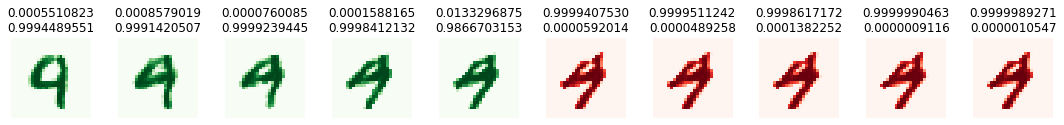

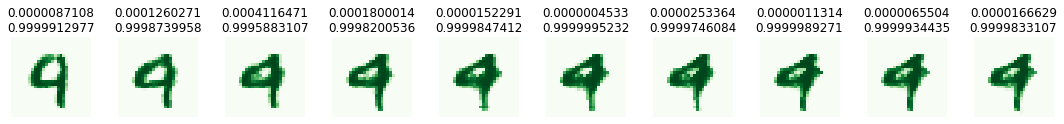

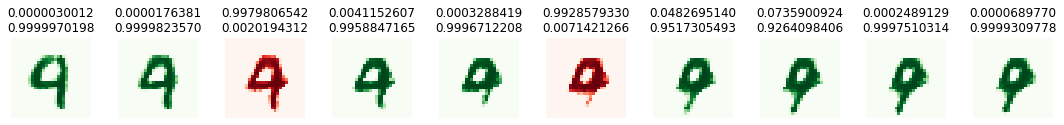

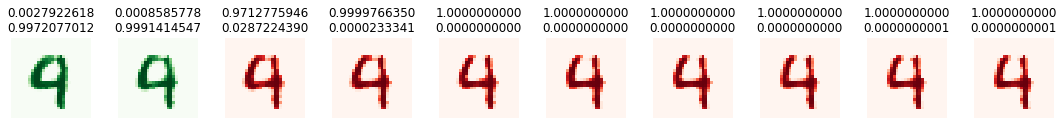

In [61]:
for i in range(10):
    plot_generated_examples_bur(1,i,True)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


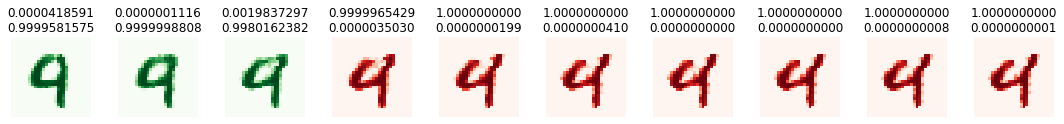

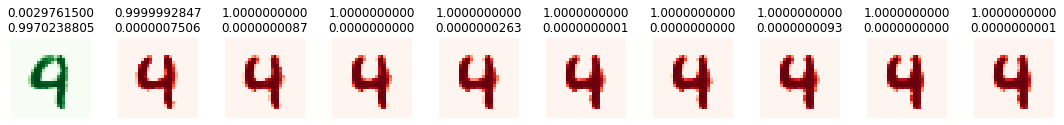

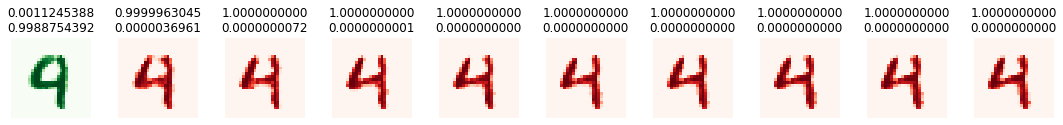

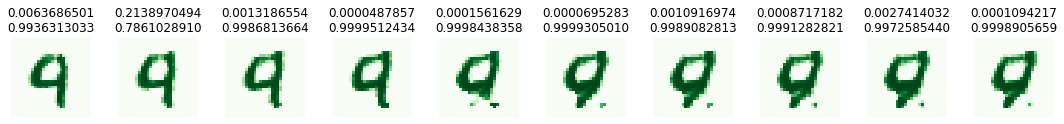

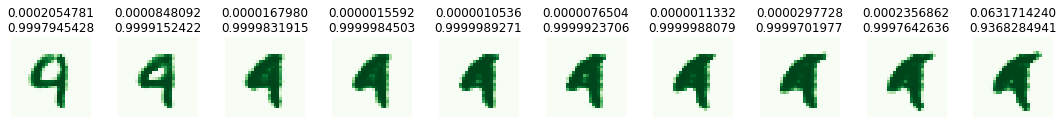

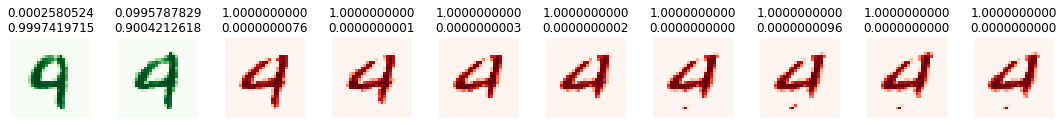

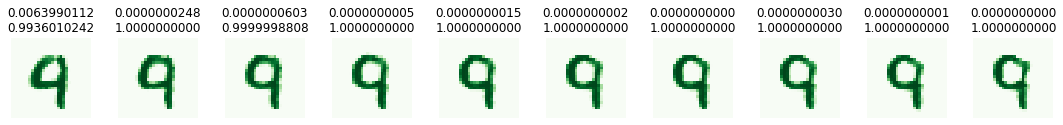

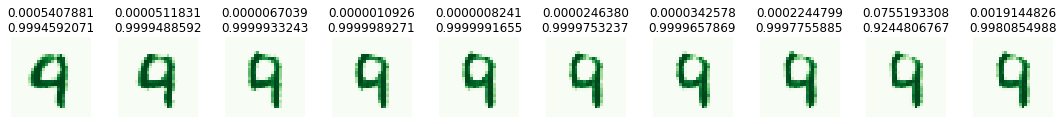

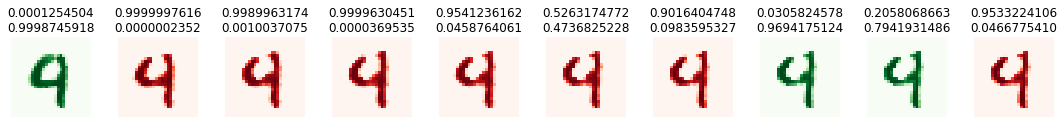

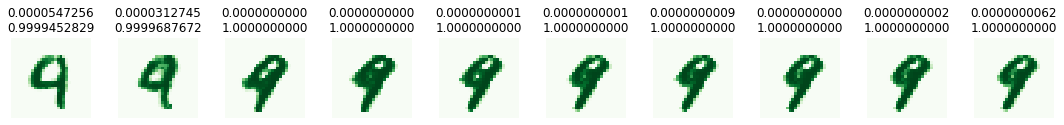

In [62]:
for i in range(10):
    plot_generated_examples_bur(1,i,False)

# Dimension 19 

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


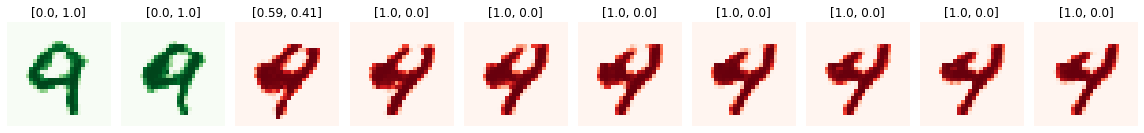

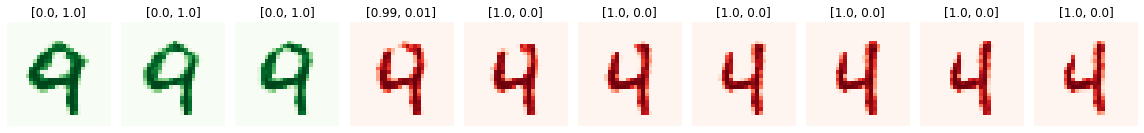

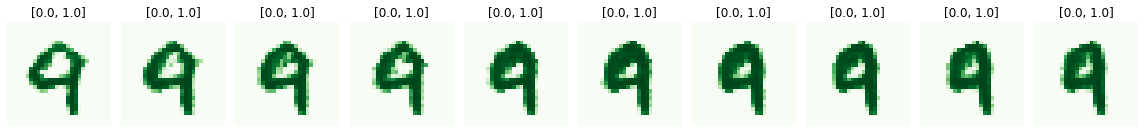

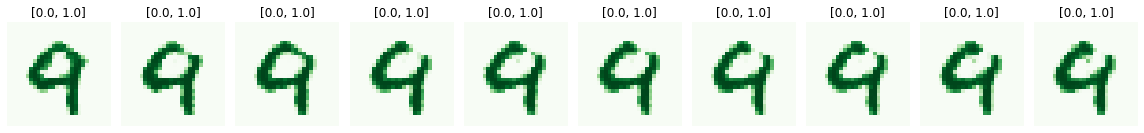

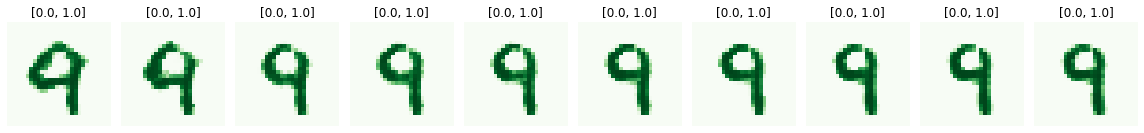

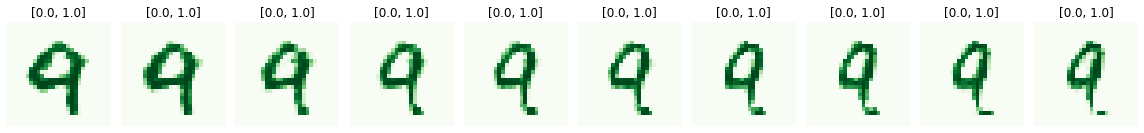

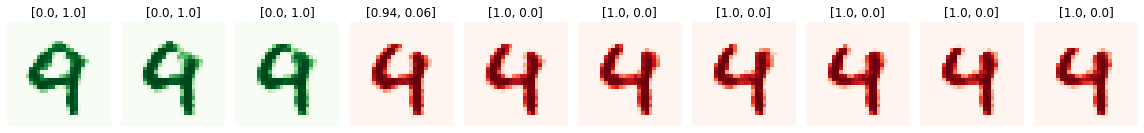

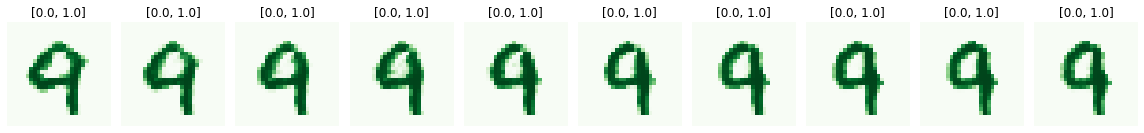

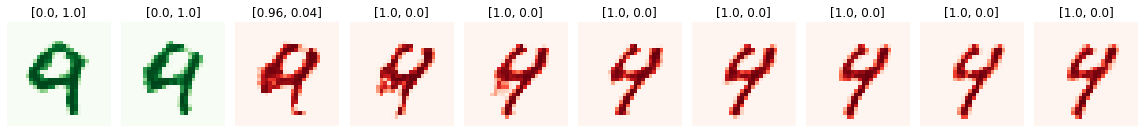

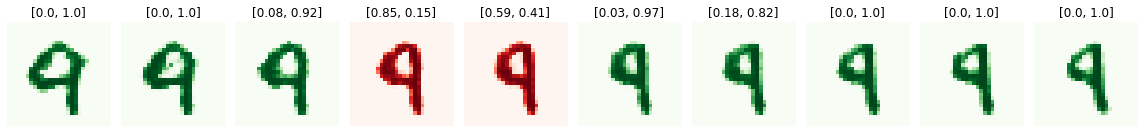

In [127]:
for i in range(10):
    plot_generated_examples_cont(1,i,True)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


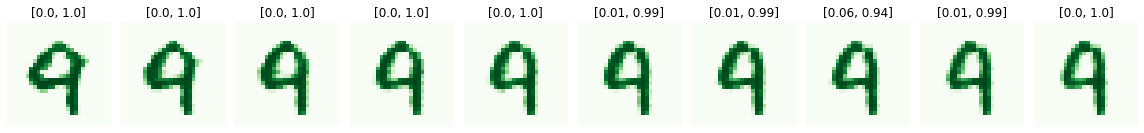

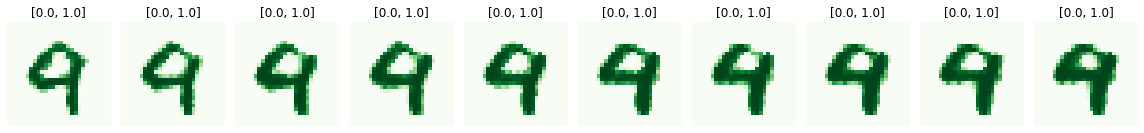

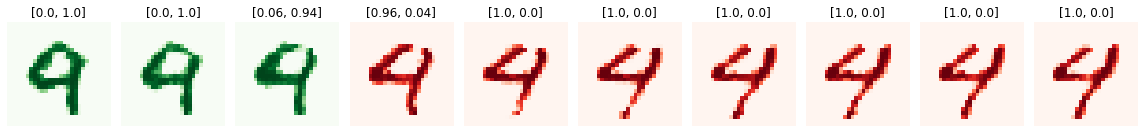

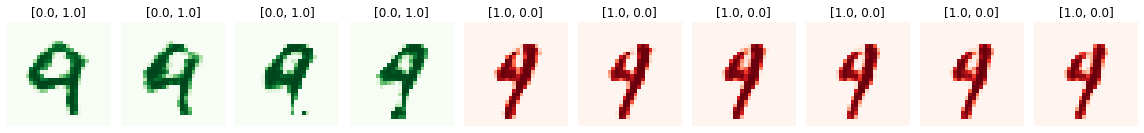

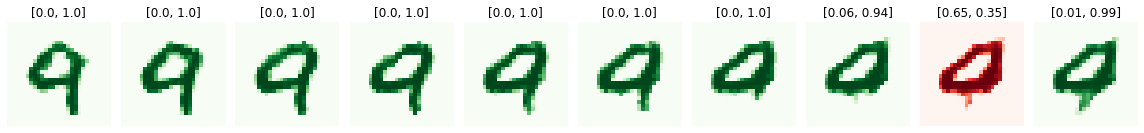

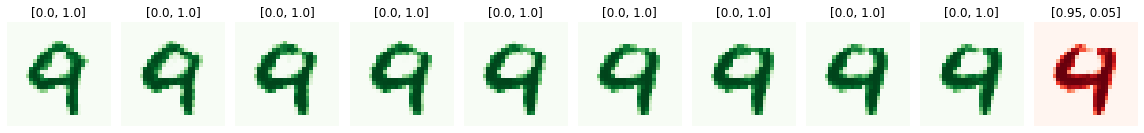

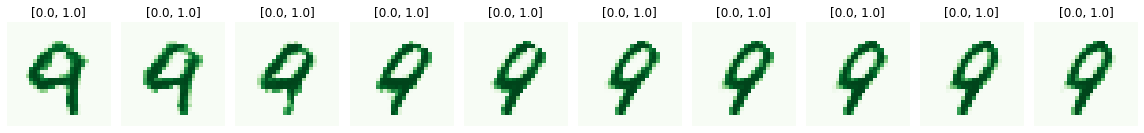

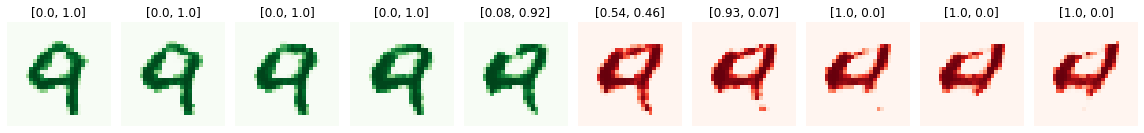

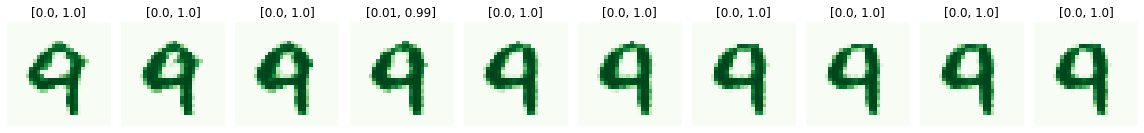

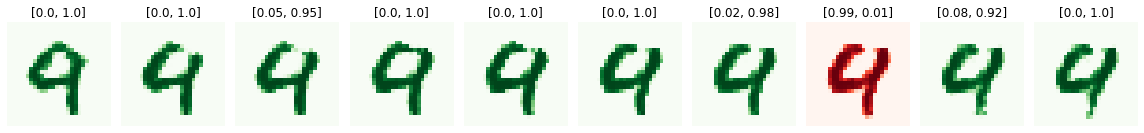

In [128]:
for i in range(10):
    plot_generated_examples_cont(1,i,False)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


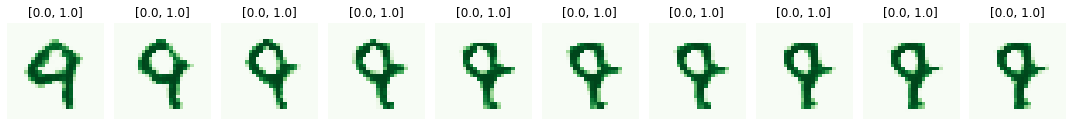

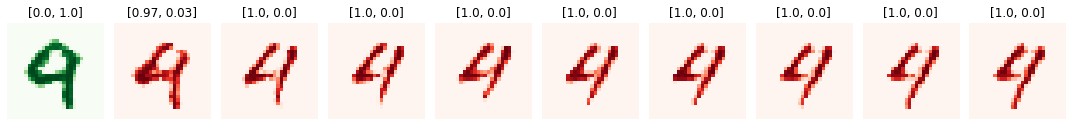

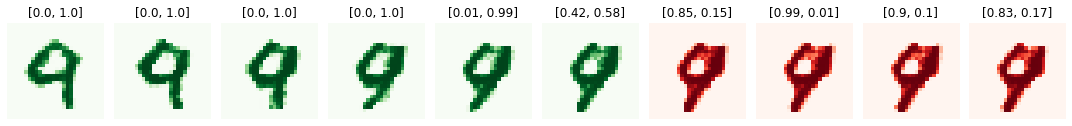

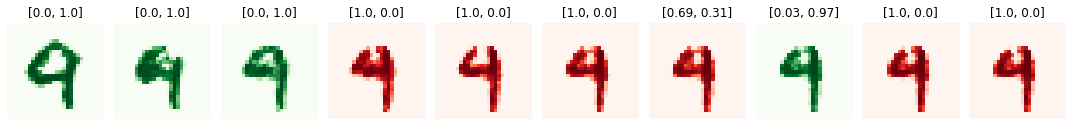

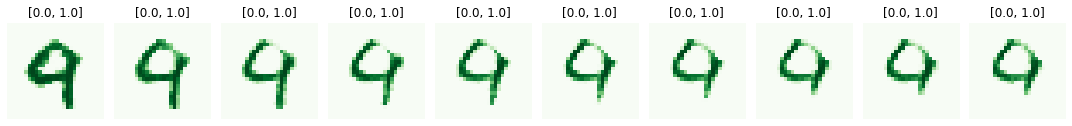

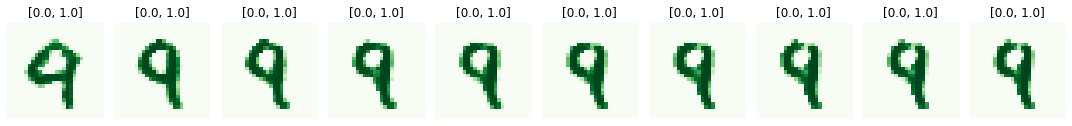

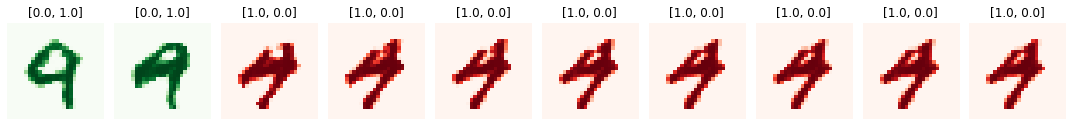

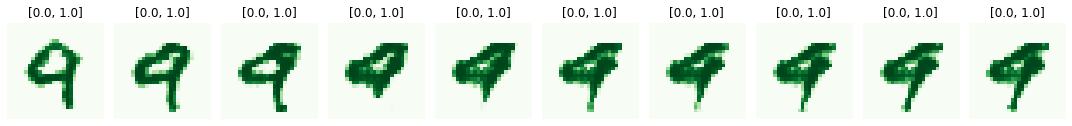

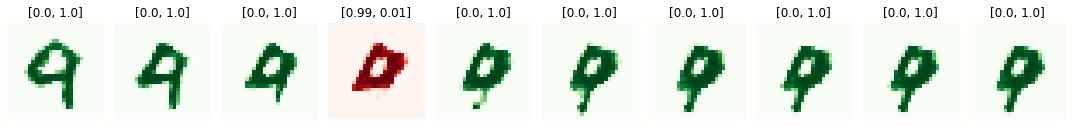

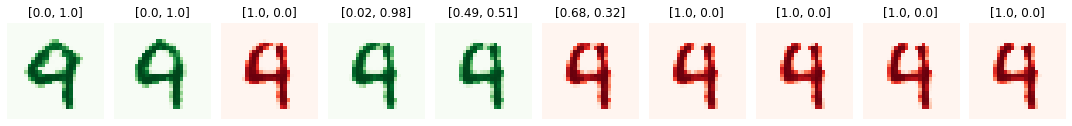

In [129]:
for i in range(10):
    plot_generated_examples_bur(1,i,True)

/home/finn/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


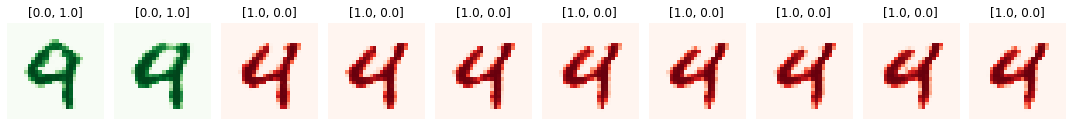

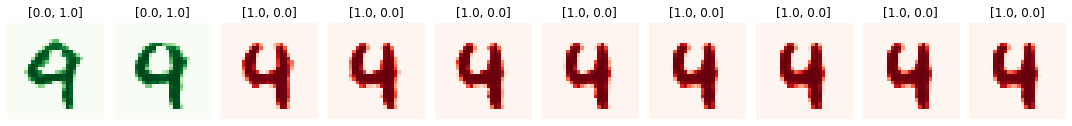

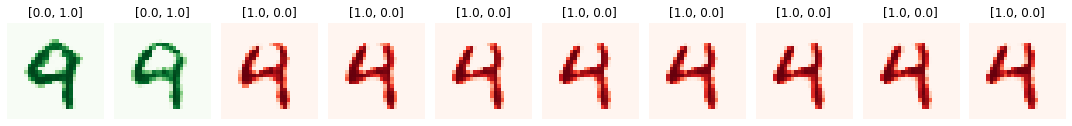

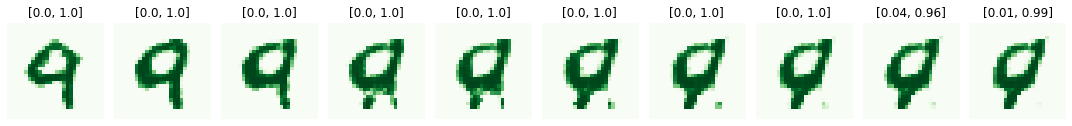

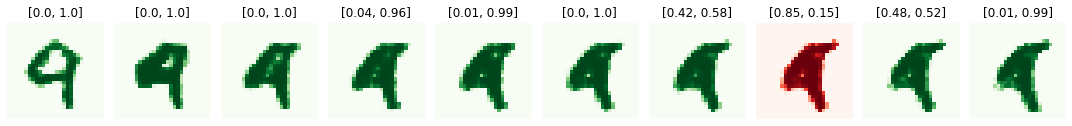

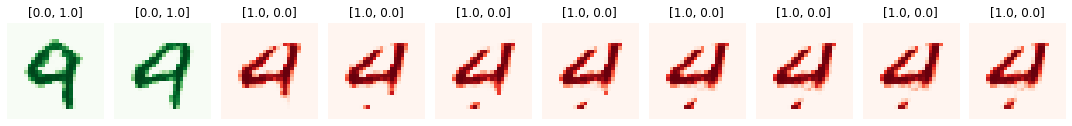

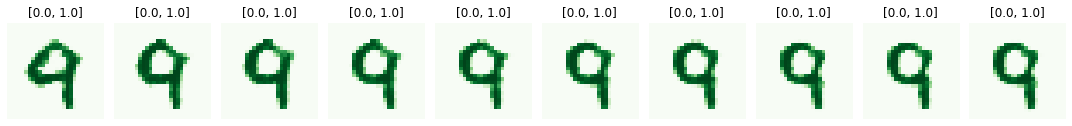

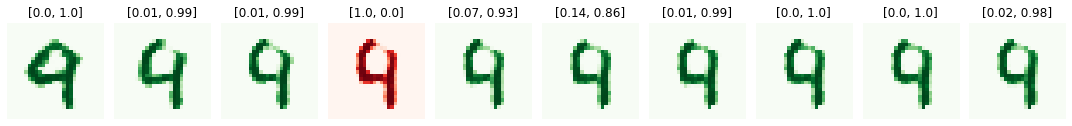

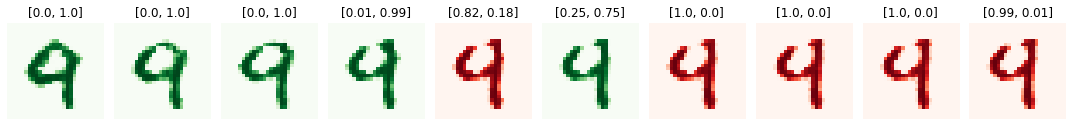

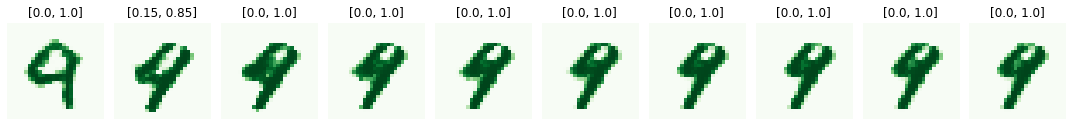

In [130]:
for i in range(10):
    plot_generated_examples_bur(1,i,False)